In [1]:
import json
# import os
# os.environ['PATH_TO_ENV'] = "~/projects/chatsky-llm-autoconfig/.env"

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dialogue2graph.pipelines.core.graph import Graph
from dialogue2graph.pipelines.models import ModelsAPI
models = ModelsAPI()

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_fields.py:192: UserWarning: Field name "validate" in "Dialogue" shadows an attribute in parent "BaseModel"
  warnings.warn(


### D2G Algo pipeline

In [42]:
from dialogue2graph.pipelines.d2g_algo.pipeline import Pipeline
from dialogue2graph.pipelines.helpers.parse_data import PipelineRawDataType
from dialogue2graph import metrics
filling_llm = models("llm", name="o3-mini", temp=1)
formatting_llm = models("llm", name="gpt-4o-mini", temp=0)
sim_model = models("similarity", name="BAAI/bge-m3", device="cuda:0")
pipeline = Pipeline("d2g_light", filling_llm, formatting_llm, sim_model, step2_evals=metrics.DGEvalBase, end_evals=[])

INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


RAW:  [{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'Do you have any other options?', 'participant': 'user'}, {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?", 'participant': 'assistant'}, {'text': "No, I'll manage on my own.", 'participant': 'user'}, {'text': 'No worries! Feel free to reach out anytime.', 'participant': 'assistant'}, {'text': 'Alright, thanks anyway.', 'participant': 'user'}, {'text': "You're welcome! Have a fantastic trip!", 'participant': 'assistant'}]
validation:  [DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need to book a ride to the airport.', participant='user'), DialogueMessage(text='Sure! I can help with

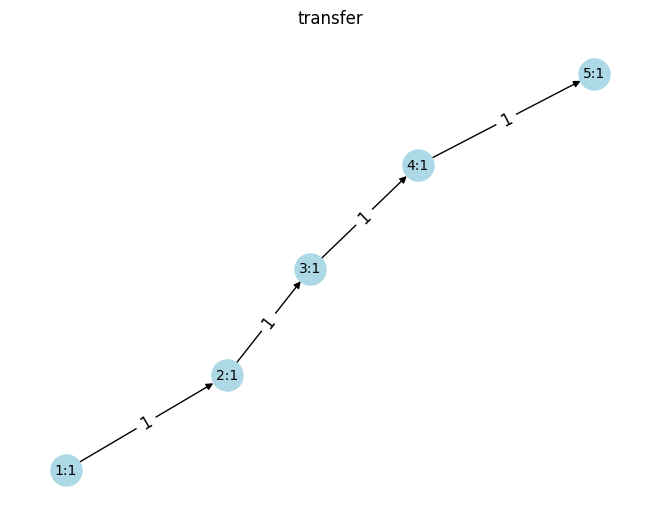

In [ ]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function callable> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


RAW:  [{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'Do you have any other options?', 'participant': 'user'}, {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?", 'participant': 'assistant'}, {'text': "No, I'll manage on my own.", 'participant': 'user'}, {'text': 'No worries! Feel free to reach out anytime.', 'participant': 'assistant'}, {'text': 'Alright, thanks anyway.', 'participant': 'user'}, {'text': "You're welcome! Have a fantastic trip!", 'participant': 'assistant'}]
validation:  [DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need to book a ride to the airport.', participant='user'), DialogueMessage(text='Sure! I can help with

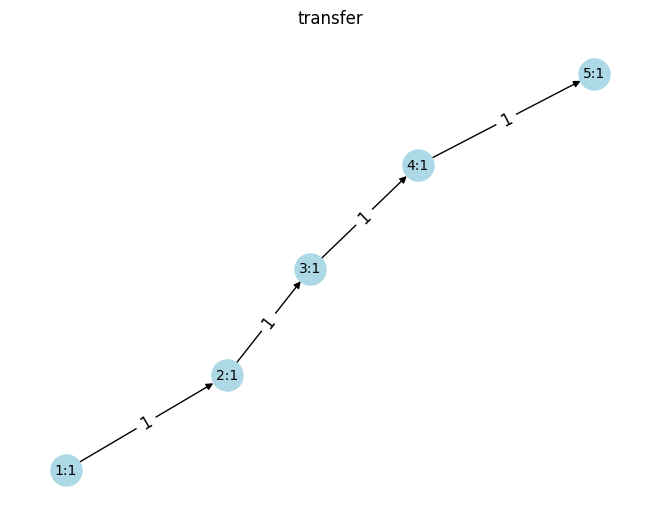

In [7]:
graph, report = pipeline.invoke(raw_data, enable_evals=True)
graph.visualise_short("transfer")

In [8]:
report

PipelineReport(service='d2g_light', properties={'time': 0.3511824607849121}, step_reports=[{}])

RAW:  [[{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'Do you have any other options?', 'participant': 'user'}, {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?", 'participant': 'assistant'}, {'text': 'Actually, never mind.', 'participant': 'user'}, {'text': 'Alright, let me know if you need help later. Have a great day!', 'participant': 'assistant'}, {'text': 'Okay, have a great day!', 'participant': 'user'}, {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}], [{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where 

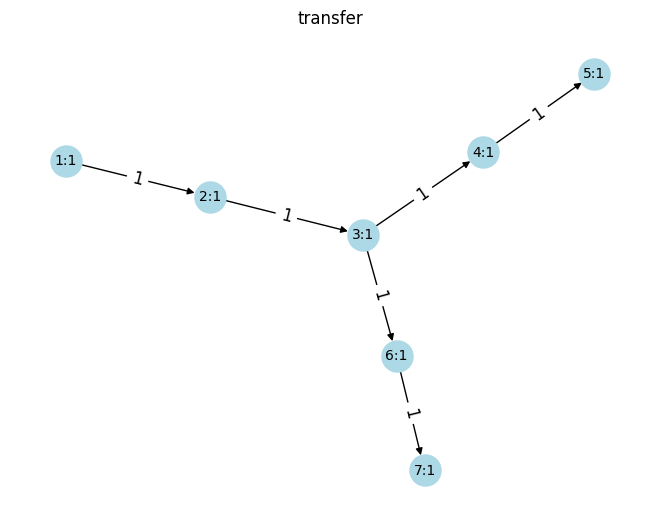

In [9]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

RAW:  [{'messages': [{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'Do you have any other options?', 'participant': 'user'}, {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?", 'participant': 'assistant'}, {'text': "No, I'll manage on my own.", 'participant': 'user'}, {'text': 'No worries! Feel free to reach out anytime.', 'participant': 'assistant'}, {'text': 'Alright, thanks anyway.', 'participant': 'user'}, {'text': "You're welcome! Have a fantastic trip!", 'participant': 'assistant'}]}]
validation:  [Dialogue(messages=[DialogueMessage(text='Hey there! How can I help you today?', participant='assistant'), DialogueMessage(text='I need to book a ride to the airport.', participant='user'), Dialogue

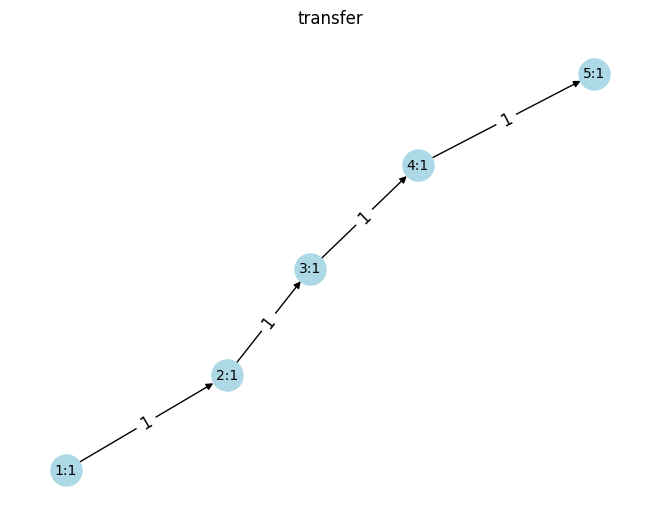

In [10]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

RAW:  [{'messages': [{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'My flight is on Saturday at 10 AM from JFK.', 'participant': 'user'}, {'text': 'Got it. Where should the driver pick you up?', 'participant': 'assistant'}, {'text': 'Pickup is from my home in Brooklyn.', 'participant': 'user'}, {'text': 'Thanks! How many passengers will be traveling?', 'participant': 'assistant'}, {'text': "It's just me traveling.", 'participant': 'user'}, {'text': 'Alright! Do you have any preference for the type of vehicle? We have sedans, SUVs, and vans available.', 'participant': 'assistant'}, {'text': 'Actually, can I change my vehicle type?', 'participant': 'user'}, {'text': 'Of course! What type of vehicle would you prefer instead?', 'participant': 'assistant'}

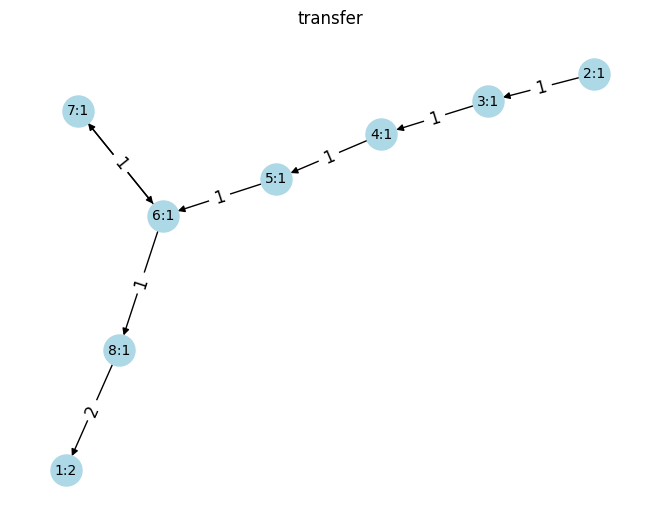

In [12]:
with open('transfer.json') as f:
    data = json.load(f)

raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

RAW:  transfer.json
validation:  transfer.json
RAW:  [{'messages': [{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'My flight is on Saturday at 10 AM from JFK.', 'participant': 'user'}, {'text': 'Got it. Where should the driver pick you up?', 'participant': 'assistant'}, {'text': 'Pickup is from my home in Brooklyn.', 'participant': 'user'}, {'text': 'Thanks! How many passengers will be traveling?', 'participant': 'assistant'}, {'text': "It's just me traveling.", 'participant': 'user'}, {'text': 'Alright! Do you have any preference for the type of vehicle? We have sedans, SUVs, and vans available.', 'participant': 'assistant'}, {'text': 'Actually, can I change my vehicle type?', 'participant': 'user'}, {'text': 'Of course! What type of vehicle would yo

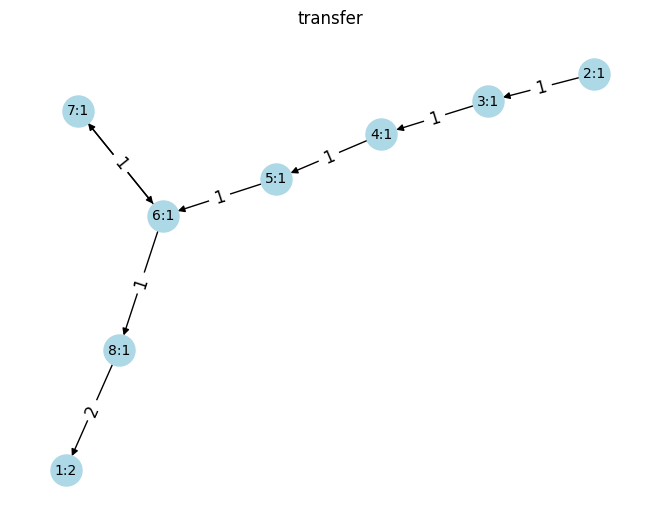

In [14]:
raw_data = PipelineRawDataType(dialogs="transfer.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

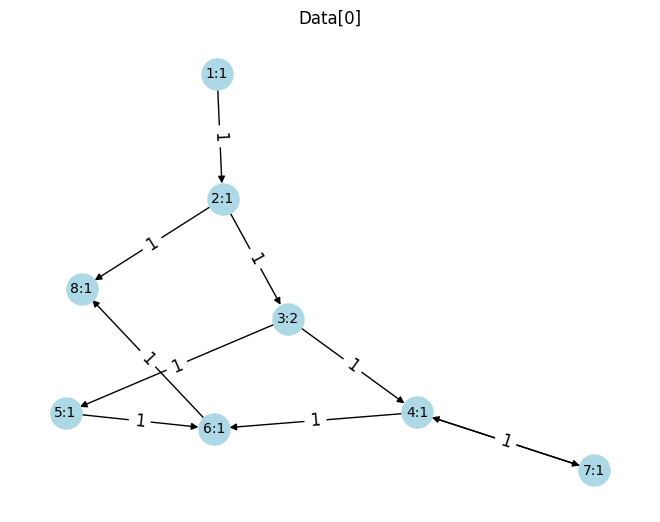

In [17]:
with open("test_metrics_data.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data[0]['graph']).visualise_short("Data[0]")

In [28]:
data[0]['graph']

{'edges': [{'source': 1,
   'target': 2,
   'utterances': ["I'm having trouble with my calendar not syncing properly."]},
  {'source': 2,
   'target': 3,
   'utterances': ["Yes, I checked but it still doesn't sync."]},
  {'source': 3,
   'target': 4,
   'utterances': ['Alright, please guide me through the steps.']},
  {'source': 4,
   'target': 6,
   'utterances': ["I've followed the steps and it seems to be working now."]},
  {'source': 2,
   'target': 8,
   'utterances': ["I think I'll handle it later. Thanks anyway."]},
  {'source': 4,
   'target': 7,
   'utterances': ['I want to change the time zone instead.']},
  {'source': 7,
   'target': 4,
   'utterances': ["Sure, let's adjust the time zone settings."]},
  {'source': 5,
   'target': 6,
   'utterances': ["After adjusting, it still doesn't sync."]},
  {'source': 3,
   'target': 5,
   'utterances': ['Time zone settings are correct, but the issue persists.']},
  {'source': 6,
   'target': 8,
   'utterances': ["Actually, it's still 

In [43]:
raw_data = PipelineRawDataType(dialogs=data[0]['dialogues'], true_graph=data[0]['graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PipelineReport(service='d2g_light', properties={'time': 2.7234456539154053}, step_reports=[{'compare_graphs:step2': {'value': True, 'description': 'Nodes similarity: 0.9999998807907104, Nodes+edges similarity: 0.9870117902755737'}, 'is_same_structure:step2': True}])

### D2G LLM pipeline

In [8]:
from dialogue2graph.pipelines.d2g_llm.pipeline import Pipeline
from dialogue2graph.pipelines.helpers.parse_data import PipelineRawDataType
from dialogue2graph import metrics
grouping_llm = models("llm", name="chatgpt-4o-latest", temp=0)
filling_llm = models("llm", name="o3-mini", temp=1)
formatting_llm = models("llm", name="gpt-4o-mini", temp=0)
sim_model = models("similarity", name="BAAI/bge-m3", device="cuda:0")
pipeline = Pipeline("d2g_llm", grouping_llm, filling_llm, formatting_llm, sim_model, step2_evals=metrics.DGEvalBase, end_evals=metrics.DGEvalBase)

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:chromadb.telemetry.product.posthog:Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


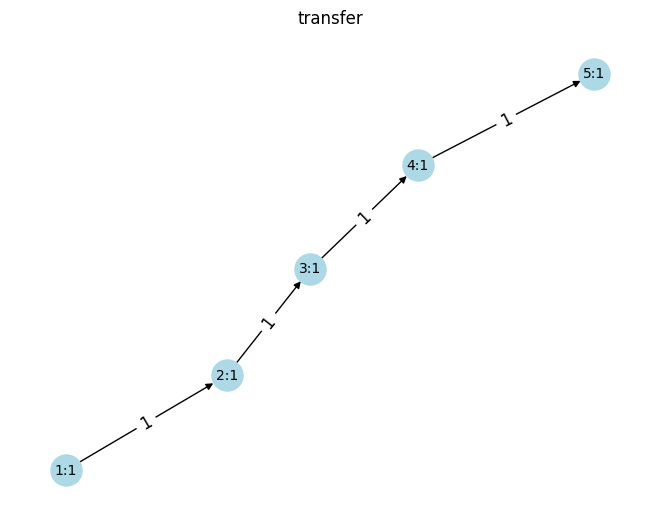

In [9]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

In [ ]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}],
   [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

In [ ]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

In [ ]:
with open('transfer.json') as f:
    data = json.load(f)
graph = pipeline.invoke(data)
graph.visualise_short("transfer")

In [ ]:
graph = pipeline.invoke("transfer.json")
graph.visualise_short("transfer")

### D2G LLM extender

In [51]:
from dialogue2graph.pipelines.d2g_extender.pipeline import Pipeline
from dialogue2graph.pipelines.helpers.parse_data import PipelineRawDataType
from dialogue2graph import metrics
extending_llm = models("llm", name="chatgpt-4o-latest", temp=0)
filling_llm = models("llm", name="o3-mini", temp=1)
formatting_llm = models("llm", name="gpt-4o-mini", temp=0)
sim_model = models("similarity", name="BAAI/bge-m3", device="cuda:0")
pipeline = Pipeline("d2g_ext", extending_llm, filling_llm, formatting_llm, sim_model,
                    step1_evals=metrics.PreDGEvalBase, extender_evals=metrics.PreDGEvalBase,
                    step2_evals=metrics.DGEvalBase, end_evals=metrics.DGEvalBase)

/home/peshkichev/miniconda3/envs/py311/lib/python3.11/site-packages/pydantic/_internal/_generate_schema.py:502: UserWarning: <built-in function callable> is not a Python type (it may be an instance of an object), Pydantic will allow any object with no validation since we cannot even enforce that the input is an instance of the given type. To get rid of this error wrap the type with `pydantic.SkipValidation`.
  warn(


In [6]:
raw_data

PipelineRawDataType(dialogs=[{'text': 'Hey there! How can I help you today?', 'participant': 'assistant'}, {'text': 'I need to book a ride to the airport.', 'participant': 'user'}, {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?', 'participant': 'assistant'}, {'text': 'Do you have any other options?', 'participant': 'user'}, {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?", 'participant': 'assistant'}, {'text': "No, I'll manage on my own.", 'participant': 'user'}, {'text': 'No worries! Feel free to reach out anytime.', 'participant': 'assistant'}, {'text': 'Alright, thanks anyway.', 'participant': 'user'}, {'text': "You're welcome! Have a fantastic trip!", 'participant': 'assistant'}], supported_graph=None, true_graph=None)

POINT:  2


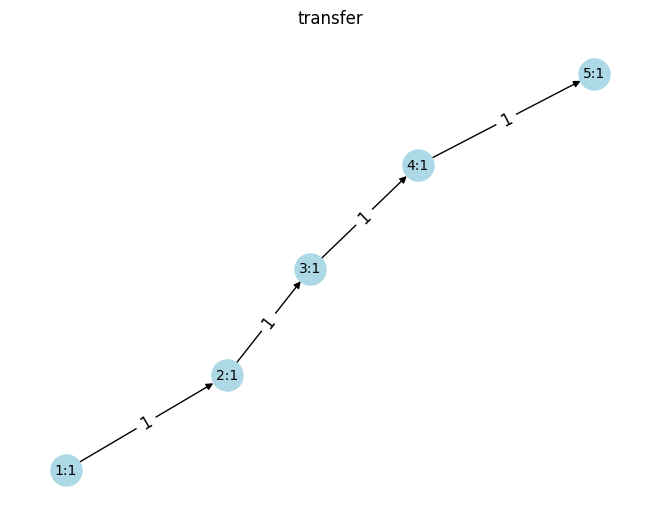

In [40]:
data = [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

CUR
POINT:  0


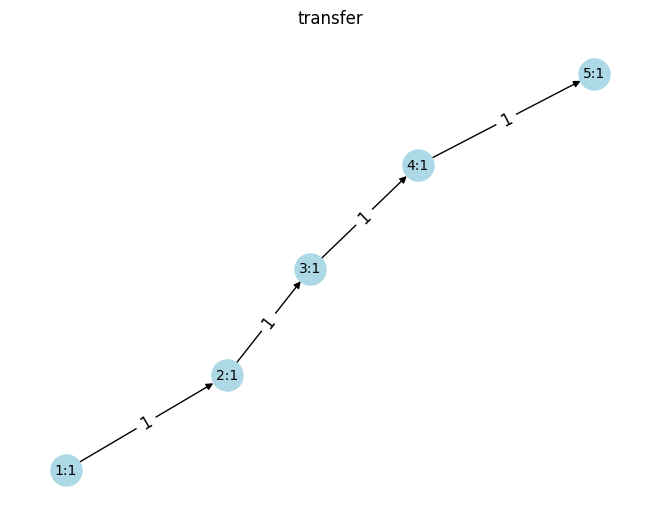

In [41]:
data = [[{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': 'Actually, never mind.', 'participant': 'user'},
   {'text': 'Alright, let me know if you need help later. Have a great day!',
    'participant': 'assistant'},
   {'text': 'Okay, have a great day!', 'participant': 'user'},
   {'text': 'Glad to help! Safe travels.', 'participant': 'assistant'}]]
raw_data = PipelineRawDataType(dialogs=data, supported_graph=graph.graph_dict)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

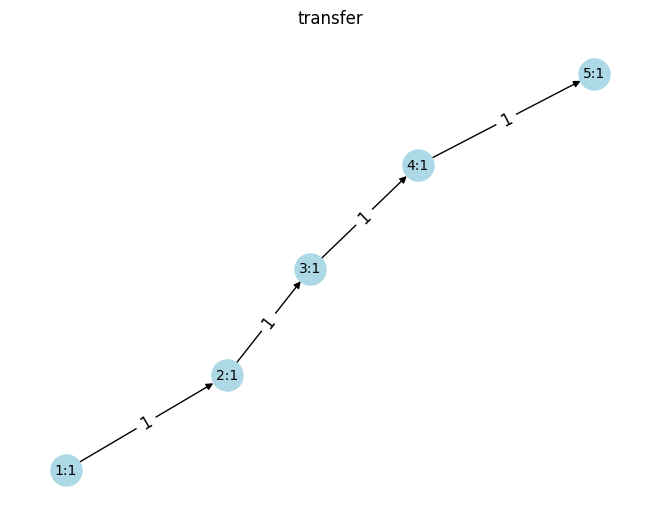

In [42]:
data = [{"messages": [{'text': 'Hey there! How can I help you today?',
    'participant': 'assistant'},
   {'text': 'I need to book a ride to the airport.', 'participant': 'user'},
   {'text': 'Sure! I can help with that. When is your flight, and where are you departing from?',
    'participant': 'assistant'},
   {'text': 'Do you have any other options?', 'participant': 'user'},
   {'text': "If you'd prefer, I can send you options for ride-share services instead. Would you like that?",
    'participant': 'assistant'},
   {'text': "No, I'll manage on my own.", 'participant': 'user'},
   {'text': 'No worries! Feel free to reach out anytime.',
    'participant': 'assistant'},
   {'text': 'Alright, thanks anyway.', 'participant': 'user'},
   {'text': "You're welcome! Have a fantastic trip!",
    'participant': 'assistant'}]}]
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

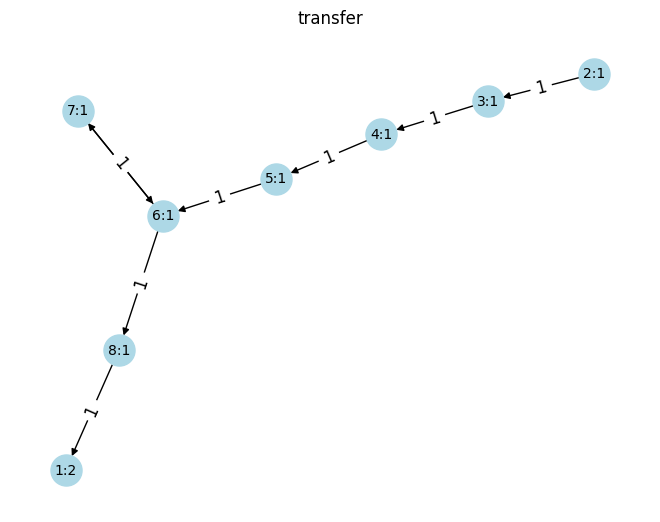

In [43]:
with open('transfer.json') as f:
    data = json.load(f)
raw_data = PipelineRawDataType(dialogs=data)
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

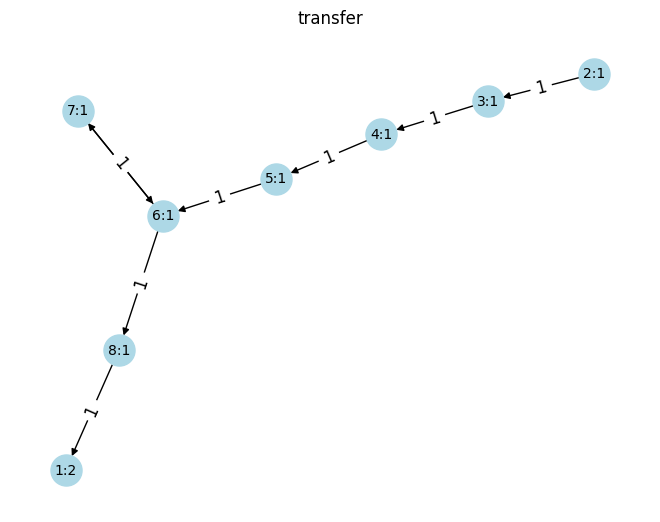

In [44]:
raw_data = PipelineRawDataType(dialogs="transfer.json")
graph, report = pipeline.invoke(raw_data)
graph.visualise_short("transfer")

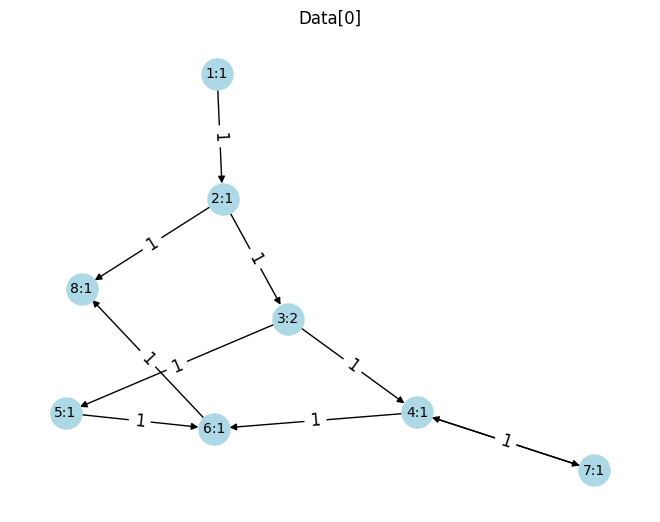

In [46]:
with open("test_metrics_data.json", encoding="utf-8") as f:
    data = json.load(f)
Graph(data[0]['graph']).visualise_short("Data[0]")

In [48]:
data

[{'graph': {'edges': [{'source': 1,
     'target': 2,
     'utterances': ["I'm having trouble with my calendar not syncing properly."]},
    {'source': 2,
     'target': 3,
     'utterances': ["Yes, I checked but it still doesn't sync."]},
    {'source': 3,
     'target': 4,
     'utterances': ['Alright, please guide me through the steps.']},
    {'source': 4,
     'target': 6,
     'utterances': ["I've followed the steps and it seems to be working now."]},
    {'source': 2,
     'target': 8,
     'utterances': ["I think I'll handle it later. Thanks anyway."]},
    {'source': 4,
     'target': 7,
     'utterances': ['I want to change the time zone instead.']},
    {'source': 7,
     'target': 4,
     'utterances': ["Sure, let's adjust the time zone settings."]},
    {'source': 5,
     'target': 6,
     'utterances': ["After adjusting, it still doesn't sync."]},
    {'source': 3,
     'target': 5,
     'utterances': ['Time zone settings are correct, but the issue persists.']},
    {'sou

In [52]:
raw_data = PipelineRawDataType(dialogs=data[0]['dialogues'], true_graph=data[0]['graph'])
graph, report = pipeline.invoke(raw_data, enable_evals=True)
report

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Graph has all the dialogues


INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: BAAI/bge-m3


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PipelineReport(service='d2g_ext', properties={'time': 12.09367060661316}, step_reports=[{'is_same_structure:step1': False, 'is_same_structure:extender': False, 'compare_graphs:step2': {'value': False, 'description': "Graphs have different number of user's utterances"}, 'is_same_structure:step2': False}])

In [12]:
graph = pipeline.invoke(data[0]['dialogues'])

INFO:httpx:HTTP Request: POST http://193.187.173.33:8002/api/providers/openai/v1/chat/completions "HTTP/1.1 200 OK"


Graph has all the dialogues


In [ ]:
graph.visualise_short("graph")

In [ ]:
Graph(data[0]['graph']).visualise_short("graph")

In [ ]:
pipeline.invoke(data[0]['dialogues'], Graph(data[0]['graph']))